In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/StageD/archive.zip

In [8]:
import tensorflow as tf
# tf.config.threading.set_inter_op_parallelism_threads(1)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
# import cv2 
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
train_df = pd.read_csv('/content/planet/planet/train_classes.csv')
print(train_df.shape)
train_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
sample_sub = pd.read_csv('/content/planet/planet/sample_submission.csv')
print (sample_sub.shape)
sample_sub.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [12]:
print(f'number of images in train data: {train_df.shape[0]}')

number of images in train data: 40479


In [13]:
# Looking on unique class in train data
train_df.tags.nunique()

449

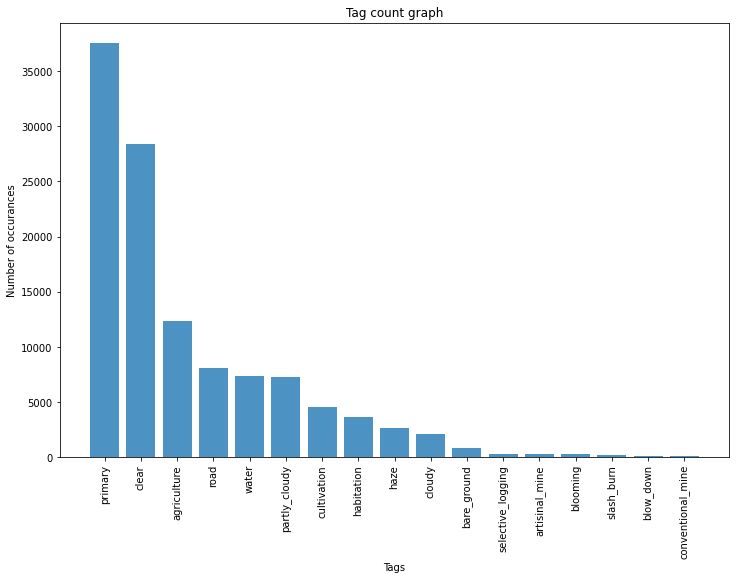

In [14]:
# tag present in train data
tag = train_df.tags.apply(lambda y: y.split(" "))
tag = [it for sublist in tag for it in sublist]
tag_count = pd.Series(tag).value_counts()

# plotting tag vs respective cout graph
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.bar(tag_count.index,tag_count.values, alpha = 0.8)
plt.title('Tag count graph')
plt.xlabel('Tags')
plt.ylabel('Number of occurances')
plt.xticks(rotation = 90)
plt.show()


****Data preprocessing****

In [15]:
labels = set()
def splitting_tags(tags):
    for tag in tags.split():
        labels.add(tag)


train_df1 = train_df.copy()
train_df1.tags.apply(splitting_tags)
labels = list(labels)
print(labels)

['blooming', 'clear', 'slash_burn', 'partly_cloudy', 'road', 'agriculture', 'artisinal_mine', 'conventional_mine', 'selective_logging', 'bare_ground', 'blow_down', 'cultivation', 'primary', 'habitation', 'cloudy', 'haze', 'water']


In [16]:
for tag in labels:
    train_df1[tag] = train_df1.tags.apply(lambda y: 1 if tag in y.split() else 0)
    
train_df1.image_name= train_df1.image_name.apply(lambda y: '{}.jpg'.format(y))
train_df1.head()

,image_name,tags,blooming,clear,slash_burn,partly_cloudy,road,agriculture,artisinal_mine,conventional_mine,selective_logging,bare_ground,blow_down,cultivation,primary,habitation,cloudy,haze,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,train_1.jpg,agriculture clear primary water,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0


In [17]:
# Importing required libraries from tensorflow for our traing dataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [18]:
columns = list(train_df1.columns[2:])
columns

['blooming',
 'clear',
 'slash_burn',
 'partly_cloudy',
 'road',
 'agriculture',
 'artisinal_mine',
 'conventional_mine',
 'selective_logging',
 'bare_ground',
 'blow_down',
 'cultivation',
 'primary',
 'habitation',
 'cloudy',
 'haze',
 'water']

In [19]:
gc.collect()

5232

In [20]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                    directory ='/content/planet/planet/train-jpg', 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=train_df1,
                                                  directory ='/content/planet/planet/train-jpg', 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [21]:
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

****Building Model****

In [22]:
def cnn():
    model = Sequential()
    #convolution layers
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same',activation = 'relu',input_shape = (128,128,3)))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #flattening the layer
    model.add(Flatten())
    
    #creating the connected layers
    model.add(Dense(units = 512,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units = 17 , activation = 'sigmoid'))
    
    #Compiling the model
    model.compile(optimizer=Adam(lr=0.001),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model
    

In [23]:
model = cnn()

#summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [24]:
earlyStop = EarlyStopping(monitor='val_loss',
                         patience = 2,
                         verbose = 1,
                         mode = 'max',
                         restore_best_weights=True
                         )


In [25]:
gc.collect()

640

In [26]:
#Callback defining
early_stop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 2,
                          verbose = 1,
                          restore_best_weights=True
                          )

In [27]:
his = model.fit(x = train_generator,
                steps_per_epoch = step_train_size,
                validation_data = val_generator,
                validation_steps = step_val_size,
                epochs = 20,
                callbacks = [early_stop]
               )

Epoch 1/20
1012/1012 [==============================] - 118s 104ms/step - loss: 0.2025 - accuracy: 0.0947 - val_loss: 0.1658 - val_accuracy: 0.1104
Epoch 2/20
1012/1012 [==============================] - 98s 96ms/step - loss: 0.1562 - accuracy: 0.1796 - val_loss: 0.1427 - val_accuracy: 0.1243
Epoch 3/20
1012/1012 [==============================] - 122s 121ms/step - loss: 0.1433 - accuracy: 0.2218 - val_loss: 0.1340 - val_accuracy: 0.1370
Epoch 4/20
1012/1012 [==============================] - 99s 98ms/step - loss: 0.1350 - accuracy: 0.2263 - val_loss: 0.1310 - val_accuracy: 0.1481
Epoch 5/20
1012/1012 [==============================] - 98s 97ms/step - loss: 0.1273 - accuracy: 0.2391 - val_loss: 0.1316 - val_accuracy: 0.1547
Epoch 6/20
1012/1012 [==============================] - 97s 96ms/step - loss: 0.1194 - accuracy: 0.2161 - val_loss: 0.1230 - val_accuracy: 0.2112
Epoch 7/20
1012/1012 [==============================] - 90s 89ms/step - loss: 0.1132 - accuracy: 0.2288 - val_loss: 0.12

In [28]:
gc.collect()

541

Ploting accuracy of traning and validation vs loss curves

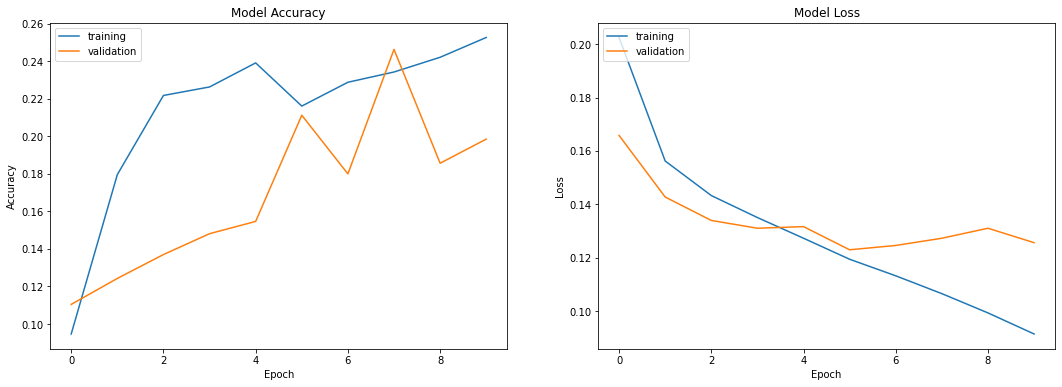

In [29]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot (his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [30]:
gc.collect()

7268

In [31]:
#This model used to predictions
model = cnn()

In [32]:
submission = pd.read_csv('/content/planet/planet/sample_submission.csv')
submission_1 = submission.copy()
submission_1.image_name = submission_1.image_name.apply(lambda x: '{}.jpg'.format(x))
submission_1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [36]:
#Dividing the sample submission file into two part
#first test contains first 40669 images

test_1 = submission_1.iloc[:40669]['image_name'].reset_index().drop('index',axis = 1)
test_1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [37]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=test_1, 
                                            directory='/content/planet/planet/test-jpg', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 40669 validated image filenames.


In [38]:
test_gen1.reset()
pred1 = model.predict(test_gen1, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 92s 72ms/step


In [39]:
file_names = test_gen1.filenames

pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear slash_burn partly_cloudy agriculture art...
1,test_1.jpg,clear slash_burn partly_cloudy agriculture art...
2,test_2.jpg,clear slash_burn partly_cloudy agriculture art...
3,test_3.jpg,clear slash_burn partly_cloudy agriculture art...
4,test_4.jpg,clear slash_burn partly_cloudy agriculture art...


In [40]:
test2_df = submission_1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [42]:
test_generator2 = test_datagen.flow_from_dataframe(dataframe=test2_df, 
                                                directory="/content/test-jpg-additional/test-jpg-additional", 
                                                x_col="image_name", y_col=None, batch_size=16, 
                                                shuffle=False, class_mode=None, target_size=(128,128))

step_test_size2 = int(np.ceil(test_generator2.samples/test_generator2.batch_size))

Found 20522 validated image filenames.


In [43]:
 
test_generator2.reset()
pred2 = model.predict(test_generator2, steps = step_test_size2, verbose = 1)

1283/1283 [==============================] - 46s 35ms/step


In [45]:
file_names2 = test_generator2.filenames


pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)


result2 = pd.DataFrame({'image_name': file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clearslash_burnpartly_cloudyagricultureartisin...
1,file_1.jpg,clearslash_burnpartly_cloudyagricultureartisin...
2,file_10.jpg,clearslash_burnpartly_cloudyagricultureartisin...
3,file_100.jpg,clearslash_burnpartly_cloudyagricultureartisin...
4,file_1000.jpg,clearslash_burnpartly_cloudyagricultureartisin...


In [46]:
lastresult = pd.concat([result1, result2])

lastresult = lastresult.reset_index().drop('index', axis =1)

print(lastresult.shape)

lastresult.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear slash_burn partly_cloudy agriculture art...
1,test_1.jpg,clear slash_burn partly_cloudy agriculture art...
2,test_2.jpg,clear slash_burn partly_cloudy agriculture art...
3,test_3.jpg,clear slash_burn partly_cloudy agriculture art...
4,test_4.jpg,clear slash_burn partly_cloudy agriculture art...


In [47]:
lastresult['image_name'] = lastresult['image_name'].apply(lambda x: x[:-4])
lastresult.head()

,image_name,tags
0,test_0,clear slash_burn partly_cloudy agriculture art...
1,test_1,clear slash_burn partly_cloudy agriculture art...
2,test_2,clear slash_burn partly_cloudy agriculture art...
3,test_3,clear slash_burn partly_cloudy agriculture art...
4,test_4,clear slash_burn partly_cloudy agriculture art...


In [48]:
lastresult.to_csv('submission.csv', index = False)

In [50]:
submission.shape

(61191, 2)